In [63]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import utils, icnn_pytorch_adaptive as icnn_pytorch

In [64]:
def dynamics(x, u, d, DT):
    # U = np.array([-np.ones_like(x[..., 2]).reshape(-1, 1), np.ones_like(x[..., 2]).reshape(-1, 1)]).T.squeeze()
    p = x[..., -1]
    # u = 2*p - 1
    # d = 2*p - 1
    dt = DT
    x1_new = x[..., 1].reshape(-1, 1) + (x[..., 2] * dt + 0.5 * u * dt ** 2).reshape(-1, 1)
    x2_new = x[..., 3].reshape(-1, 1) + (x[..., 4] * dt + 0.5 * d * dt ** 2).reshape(-1, 1)
    v1_new = x[..., 2].reshape(-1, 1) + u * dt
    v2_new = x[..., 4].reshape(-1, 1) + d * dt

    # v_new = np.array([x[..., 2] + a for a in da_v]).T.reshape(-1, 1)
    # p_new = np.multiply(x[:, 3].reshape(-1, 1),
    #                     np.ones((x.shape[0], 4))).reshape(-1, 1)
    X_new = np.hstack((x1_new.reshape(-1, 1), v1_new.reshape(-1, 1), x2_new.reshape(-1, 1),
                       v2_new.reshape(-1, 1)))  # returns new states, n x 8

    return X_new

In [65]:
def initial_payoff_term(x, K1, K2, Phi):
    """

    :param x: current state
    :param K1: current K matrix
    :param Phi: current Phi matrix
    :return: "initial payoff"
    """
    p = x[..., -1].reshape(-1, 1)  # belief
    x = x[..., 1:-1]  # state 1:-1 or 0:-1 depending on if time is included
    x1 = x[..., :2]  # player 1's state
    x2 = x[..., 2:]  # player 2's state

    ztheta = np.concatenate((np.ones_like(p), np.zeros_like(p)), axis=1).T

    term1 = p * ((x1.T - (Phi @ ztheta)).T.dot(K1) * ((x1.T - (Phi @ ztheta)).T)).sum(axis=1).reshape(-1, 1) + \
            (1 - p) * ((x1.T + (Phi @ ztheta)).T.dot(K1) * ((x1.T + (Phi @ ztheta)).T)).sum(axis=1).reshape(-1, 1)

    # term1 = p * np.sum(K1 @ np.square(x1.T - (Phi @ ztheta)), axis=0).reshape(-1, 1) + \
    #         (1 - p) * np.sum(K1 @ np.square(x1.T + (Phi @ ztheta)), axis=0).reshape(-1, 1)

    term2 = p * ((x2.T - (Phi @ ztheta)).T.dot(K2) * ((x2.T - (Phi @ ztheta)).T)).sum(axis=1).reshape(-1, 1) + \
            (1 - p) * ((x2.T + (Phi @ ztheta)).T.dot(K2) * ((x2.T + (Phi @ ztheta)).T)).sum(axis=1).reshape(-1, 1)

    return term1 - term2

In [56]:
def get_d_inst(tilde_theta, p_next, d1, d2):
    term1 = p_next.numpy() * ((tilde_theta.numpy() - 1) ** 2) * (d1 - d2)
    term2 = (1 - p_next.numpy()) * (tilde_theta.numpy() + 1) ** 2 * (d1 - d2)

    return term1 + term2

In [66]:
ckpt_path = '../logs/hexner_train_R2_timestep_0.1_with_d_new/t_1/checkpoints_dir/model_final.pth'
model_2 = '../logs/hexner_train_R2_timestep_0.1_with_d_new/t_1/checkpoints_dir/model_final.pth'
# ckpt_path = '../logs/hexner_train_R2_timestep_0.1/t_10/checkpoints_dir/model_final.pth'
# model_2 = '../logs/hexner_train_R2_timestep_0.1/t_9/checkpoints_dir/model_final.pth'
activation = 'relu'

model = icnn_pytorch.SingleBVPNet(in_features=6, out_features=1, type=activation, mode='mlp', hidden_features=128, num_hidden_layers=2, dropout=0)
model2 = icnn_pytorch.SingleBVPNet(in_features=6, out_features=1, type=activation, mode='mlp', hidden_features=128, num_hidden_layers=2, dropout=0)

checkpoint = torch.load(ckpt_path, map_location=torch.device("cpu"))
c2 = torch.load(model_2, map_location=torch.device("cpu"))

try:
    model_weights = checkpoint['model']
except:
    model_weights = checkpoint

try:
    mw = c2['model']
except:
    mw = c2

model.load_state_dict(model_weights)
model2.load_state_dict(mw)
model.eval()
model2.eval()

SingleBVPNet(
  (net): FCBlock(
    (nl): ReLU(inplace=True)
    (net_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=5, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_zu_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_z_zu): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=False)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=1, bias=False)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_yu_u)

SingleBVPNet(
  (net): FCBlock(
    (nl): ReLU(inplace=True)
    (net_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=5, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_zu_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_z_zu): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=False)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=1, bias=False)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_yu_u)

In [67]:
X = torch.zeros((100, 5))
p_T = torch.linspace(0, 1, 100).reshape(-1, 1)

R1 = 1
R2 = 5

K_1, Phi_1 = utils.solve_hexner(R1)
K_2, Phi_2 = utils.solve_hexner(R2)
d1 = utils.compute_d(Phi_1, K_1, R1)
d2 = utils.compute_d(Phi_2, K_2, R2)

X = torch.cat((X, p_T), dim=1)
X_ini = X  # for future

t_1 = 0.1
t_step = int(t_1 * 10)

X[:, 0] = t_1 # time
X[:, 1] = 0. # x1
X[:, 2] = 0. # v1
X[:, 3] = 0. # x2
X[:, 4] = 0. # v2
X_in = {'coords': X}
u2 = model(X_in)['model_out'].detach().cpu().numpy()
v2 = u2 + initial_payoff_term(X_ini.detach().cpu().numpy(), K_1[-t_step], K_2[-t_step], Phi_1[-t_step])

In [68]:
initial_payoff_term(X_ini.detach().cpu().numpy(), K_1[-t_step], K_2[-t_step], Phi_1[-t_step])

array([[-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0.00024483],
       [-0

In [73]:
## check min max value for t = T - delta t
delta_t = 0.1
V1 = []
t = t_1 - delta_t
actions = []

values = []
inst_terms = []
# X = torch.tensor([[t, delta_x, delta_v]], dtype=torch.float32)
for p in torch.linspace(0, 1, 100):
    X = torch.zeros((1, 5))
    X[:, 1] = 0.
    X[:, 2] = 0.
    X[:, 3] = 0.
    X[:, 4] = 0.
    p_T = p.reshape(-1, 1)
    X = torch.cat((X, p_T), dim=1)
    # u = (2 * p_T - 1).detach().cpu().numpy()
    p_next = p_T

    if t_1 >= 0.5:
        tilde_theta = torch.zeros_like(p_next)
    else:
        tilde_theta = 2 * p_next - 1  # action

    inst_term = delta_t * get_d_inst(tilde_theta, p_next, d1[-t_step], d2[-t_step])
    ztheta = np.concatenate((2 * p_T - 1, np.zeros_like(p_T)), axis=1)
    u = utils.get_analytical_u(K_1[-t_step], R1, Phi_1[-t_step], X[:, 1:3].detach().cpu().numpy().T, ztheta.T).flatten()
    d = utils.get_analytical_u(K_2[-t_step], R2, Phi_2[-t_step], X[:, 3:5].detach().cpu().numpy().T, ztheta.T).flatten()
    X_new = torch.from_numpy(dynamics(X, u, d, DT=delta_t))
    X_new = torch.cat((torch.ones(X_new.shape[0], 1), X_new), dim=1)
    X_in = torch.cat((X_new, p_T), dim=1).to(torch.float32)
    X_in[:, 0] = t
    X_in = {'coords': X_in}
    # value = model2(X_in)['model_out'].detach().cpu().numpy()
    # value = utils.final_value(X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, -1]).numpy()
    if t_1 == delta_t:
        value = inst_term #get_d_inst(tilde_theta, p_next, d1[-t_step], d2[-t_step])

        values.append(value.item())
    else:
        value = model2(X_in)['model_out'].detach().cpu().numpy()

        values.append(value.item())
        inst_terms.append(inst_term.item())
        value += inst_term#get_d_inst(tilde_theta, p_next, d1[-t_step], d2[-t_step])
    # try:
    #     minmaxV = (value + delta_t * get_running_payoff(u, d, R1, R2))[0][0]
    # except:
    #     minmaxV = (value + delta_t * get_running_payoff(u, d, R1, R2))[0]
    try:
        V1.append(value.item())
    except:
        V1.append(value)
    # V1.append(np.min(np.max(minmaxV, 1)))

In [74]:
p = p_T.numpy()
points = zip(V1, p)
from utils import cav_vex

In [75]:
ps = np.linspace(0, 1, 100)
vex = []
for p in ps:
    vex.append(cav_vex(V1, p, type='vex', num_ps=100))

gt = vex + initial_payoff_term(X_ini.detach().cpu().numpy(), K_1[-t_step], K_2[-t_step], Phi_1[-t_step]).flatten()

In [77]:
minimax_plus_initial = V1 + initial_payoff_term(X_ini.detach().cpu().numpy(), K_1[-t_step], K_2[-t_step], Phi_1[-t_step]).flatten()

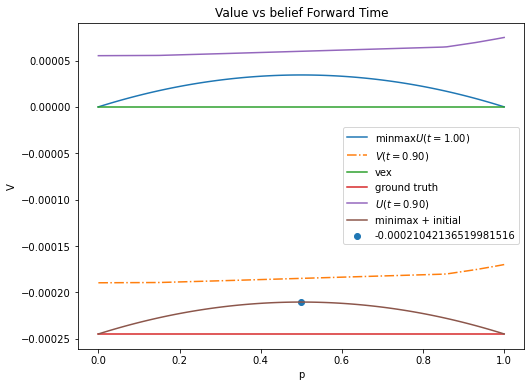

In [86]:
plt.plot(np.linspace(0, 1, 100), V1, label=f'$\min \max U(t={1 - t:.2f})$')
plt.plot(np.linspace(0, 1, 100), v2, '-.', label=f'$V(t={1-(t+delta_t):.2f})$')
plt.plot(np.linspace(0, 1, 100), vex, label='vex')
plt.plot(np.linspace(0, 1, 100), gt.reshape(-1, 1), label='ground truth')
plt.plot(np.linspace(0, 1, 100), u2.reshape(-1, 1), label=f'$U(t={1-(t+delta_t):.2f})$')

plt.plot(np.linspace(0, 1, 100), minimax_plus_initial.reshape(-1, 1), label='minimax + initial')

plt.scatter(x=0.5, y=minimax_plus_initial[49], label=str(minimax_plus_initial[49]))
plt.title('Value vs belief Forward Time')
plt.xlabel('p')
plt.ylabel('V')
plt.legend()
# plt.ylim([-0.005, 0.005])
plt.rcParams['figure.figsize'] = (8, 6)

In [81]:
minimax_plus_initial[49]

-0.00021042136519981516

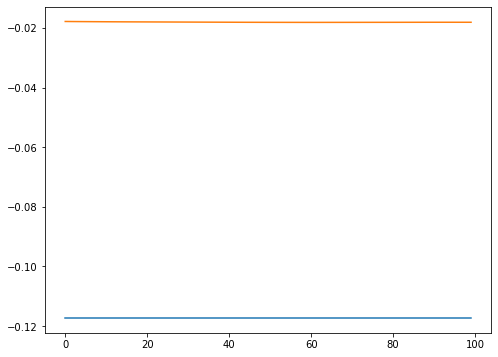

In [52]:
plt.plot(initial_payoff_term(X_ini.detach().cpu().numpy(), K_1[-t_step], K_2[-t_step], Phi_1[-t_step]).flatten())
plt.plot(V1)

In [15]:
up = 0.5
states = [up]
for _ in range(1):  # change to 9 for 10 timesteps
    states.append((states[-1] - 0.005) / 1.1)

In [16]:
states

[0.5, 0.44999999999999996]

In [17]:
t_step = int(0.5 * 100) // 2

In [18]:
t_step

25

In [575]:
np.linspace(0, 1, 3)

array([0. , 0.5, 1. ])

In [503]:
np.linspace(0, 1, 6)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [593]:
t = np.arange(0.05, 1.05, 0.05)

In [657]:
t_step = int(np.where(t == 0.05)[0] + 1)
t_step

1

In [698]:
up = 0.5
states = [up]
for _ in range(9):  # change to 9 for 10 timesteps
    states.append((states[-1] - 0.005) / 1.1)

In [699]:
states

[0.5,
 0.44999999999999996,
 0.4045454545454545,
 0.3632231404958677,
 0.3256574004507888,
 0.2915067276825352,
 0.2604606615295774,
 0.23223696502688854,
 0.20657905911535318,
 0.1832536901048665]